In [145]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

Using TensorFlow backend.


In [68]:
barts_hotspots = pd.read_csv("barts_hotspots.csv")
barts_to_all = pd.read_csv("barts_to_all.csv")
hotspots_to_all = pd.read_csv("hotspots_to_all.csv")
hours_q1 = pd.read_csv("hours_q1.csv")
hours_q2 = pd.read_csv("hours_q2.csv")

In [11]:
barts_hotspots.head()

Date  Origin Movement ID  \
0  06/09/2019                3396   
1  04/28/2019                3603   
2  05/18/2019                3603   
3  04/18/2019                3792   
4  04/08/2019                3792   

                                 Origin Display Name  Destination Movement ID  \
0  The Palace Of Fine Arts, 3601 Lyon St, San Fra...                     3603   
1                     Embarcadero, San Francisco, CA                     3394   
2                     Embarcadero, San Francisco, CA                     3394   
3  Oracle Park, 24 Willie Mays Plaza, San Francis...                     3603   
4  Oracle Park, 24 Willie Mays Plaza, San Francis...                     3603   

               Destination Display Name  Daily Mean Travel Time (Seconds)  \
0        Embarcadero, San Francisco, CA                            1588.0   
1  Fisherman's Wharf, San Francisco, CA                             639.0   
2  Fisherman's Wharf, San Francisco, CA                             730.0   
3        Embarcadero, San Francisco, CA                             512.0   
4        Embarcadero, San Francisco, CA                             505.0   

   Daily Range - Lower Bound Travel Time (Seconds)  \
0                                           1054.0   
1                                            512.0   
2                                            520.0   
3                                            371.0   
4                                            364.0   

   Daily Range - Upper Bound Travel Time (Seconds)  \
0                                           2392.0   
1                                            796.0   
2                                           1024.0   
3                                            705.0   
4                                            701.0   

   AM Mean Travel Time (Seconds)  \
0                            NaN   
1                            NaN   
2                            NaN   
3                          648.0   
4                          621.0   

   AM Range - Lower Bound Travel Time (Seconds)  ...  \
0                                           NaN  ...   
1                                           NaN  ...   
2                                           NaN  ...   
3                                         461.0  ...   
4                                         489.0  ...   

   PM Range - Upper Bound Travel Time (Seconds)  \
0                                           NaN   
1                                         793.0   
2                                         985.0   
3                                         720.0   
4                                         941.0   

   Midday Mean Travel Time (Seconds)  \
0                                NaN   
1                              654.0   
2                              791.0   
3                              528.0   
4                              429.0   

   Midday Range - Lower Bound Travel Time (Seconds)  \
0                                               NaN   
1                                             524.0   
2                                             590.0   
3                                             398.0   
4                                             339.0   

   Midday Range - Upper Bound Travel Time (Seconds)  \
0                                               NaN   
1                                             817.0   
2                                            1061.0   
3                                             702.0   
4                                             542.0   

   Evening Mean Travel Time (Seconds)  \
0                                 NaN   
1                               608.0   
2                               569.0   
3                               442.0   
4                               502.0   

   Evening Range - Lower Bound Travel Time (Seconds)  \
0                                                NaN   
1                                              492.0   
2      

In [9]:
ids_of_interest = barts_hotspots['Origin Movement ID'].unique()
dest_of_interest = barts_hotspots['Origin Display Name'].unique()
id_names = dict(zip(ids_of_interest, dest_of_interest))
id_names

{3396: 'The Palace Of Fine Arts, 3601 Lyon St, San Francisco, CA',
 3603: 'Embarcadero, San Francisco, CA',
 3792: 'Oracle Park, 24 Willie Mays Plaza, San Francisco, CA',
 3394: "Fisherman's Wharf, San Francisco, CA",
 3692: '2nd Street and Stevenson Street (Montgomery BART, San Francisco, CA',
 3760: 'Powell BART Station, Market St and Powell St, San Francisco, CA'}

In [60]:
barts_hotspots_null = barts_hotspots.isnull().sum()
barts_hotspots_null

Date                                                          0
Origin Movement ID                                            0
Origin Display Name                                           0
Destination Movement ID                                       0
Destination Display Name                                      0
Daily Mean Travel Time (Seconds)                             58
Daily Range - Lower Bound Travel Time (Seconds)              58
Daily Range - Upper Bound Travel Time (Seconds)              58
AM Mean Travel Time (Seconds)                              1466
AM Range - Lower Bound Travel Time (Seconds)               1466
AM Range - Upper Bound Travel Time (Seconds)               1466
PM Mean Travel Time (Seconds)                               928
PM Range - Lower Bound Travel Time (Seconds)                928
PM Range - Upper Bound Travel Time (Seconds)                928
Midday Mean Travel Time (Seconds)                           727
Midday Range - Lower Bound Travel Time (

Getting the mean time to go from Hotspots to BART

In [49]:
hotspot_origin = [3396,3792,3394]
palace_origin = barts_hotspots[barts_hotspots['Origin Movement ID']==3396]
oracle_origin = barts_hotspots[barts_hotspots['Origin Movement ID']==3792]
wharf_origin = barts_hotspots[barts_hotspots['Origin Movement ID']==3394]

palace_origin = palace_origin[np.isfinite(palace_origin['Daily Mean Travel Time (Seconds)'])]
oracle_origin = oracle_origin[np.isfinite(oracle_origin['Daily Mean Travel Time (Seconds)'])]
wharf_origin = wharf_origin[np.isfinite(wharf_origin['Daily Mean Travel Time (Seconds)'])]

palace_embar = palace_origin[palace_origin["Destination Movement ID"]==3603]["Daily Mean Travel Time (Seconds)"].mean()
palace_mont = palace_origin[palace_origin["Destination Movement ID"]==3692]["Daily Mean Travel Time (Seconds)"].mean()
palace_powell = palace_origin[palace_origin["Destination Movement ID"]==3760]["Daily Mean Travel Time (Seconds)"].mean()

oracle_embar = oracle_origin[oracle_origin["Destination Movement ID"]==3603]["Daily Mean Travel Time (Seconds)"].mean()
oracle_mont = oracle_origin[oracle_origin["Destination Movement ID"]==3692]["Daily Mean Travel Time (Seconds)"].mean()
oracle_powell = oracle_origin[oracle_origin["Destination Movement ID"]==3760]["Daily Mean Travel Time (Seconds)"].mean()

wharf_embar = wharf_origin[wharf_origin["Destination Movement ID"]==3603]["Daily Mean Travel Time (Seconds)"].mean()
wharf_mont = wharf_origin[wharf_origin["Destination Movement ID"]==3692]["Daily Mean Travel Time (Seconds)"].mean()
wharf_powell = wharf_origin[wharf_origin["Destination Movement ID"]==3760]["Daily Mean Travel Time (Seconds)"].mean()


Draw the graph of the average time (seconds) to go from Hotspots to BART

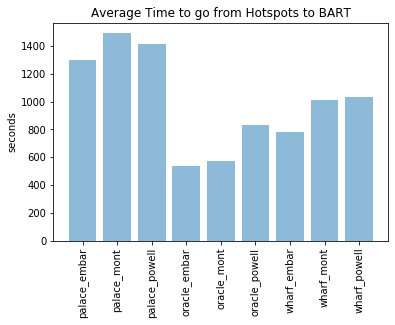

In [51]:
objects = ('palace_embar', 'palace_mont', 'palace_powell','oracle_embar','oracle_mont','oracle_powell','wharf_embar','wharf_mont','wharf_powell')
y_pos = np.arange(len(objects))
performance = [palace_embar,palace_mont,palace_powell,oracle_embar,oracle_mont,oracle_powell,wharf_embar,wharf_mont,wharf_powell]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('seconds')
plt.title('Average Time to go from Hotspots to BART')

plt.show()

Get all the route from palace to embar

In [120]:
palace_embar_df = palace_origin[palace_origin["Destination Movement ID"]==3603]
palace_embar_df = palace_embar_df[["Date","Daily Mean Travel Time (Seconds)"]]

#Convert o datetime format
palace_embar_df['Date'] = pd.to_datetime(palace_embar_df['Date'])

#Drop null values
palace_embar_df = palace_embar_df.dropna()

#Sort by datetime
palace_embar_df = palace_embar_df.sort_values(by='Date')
print(palace_embar_df)

           Date  Daily Mean Travel Time (Seconds)
1864 2019-01-01                            1450.0
1649 2019-01-02                            1224.0
1793 2019-01-03                            1385.0
1759 2019-01-04                            1143.0
2075 2019-01-05                            1216.0
1923 2019-01-07                            1364.0
2016 2019-01-08                            1458.0
1815 2019-01-09                            1190.0
1693 2019-01-10                            1426.0
1900 2019-01-11                            1317.0
1949 2019-01-12                            1251.0
1869 2019-01-13                            1225.0
2079 2019-01-14                            1551.0
1741 2019-01-15                            1338.0
1780 2019-01-16                            1304.0
1784 2019-01-17                            1396.0
1791 2019-01-18                            1380.0
1729 2019-01-19                            1174.0
1859 2019-01-20                            1213.0


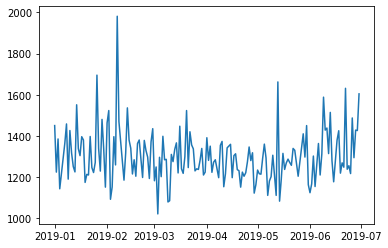

In [106]:
#Plot 
plt.plot(palace_embar_df['Date'], palace_embar_df['Daily Mean Travel Time (Seconds)'])
plt.show()

In [112]:
# The following code for data preparing and LSTM Model building is adapted from 
#"Time Series Forecasting with the Long Short-Term Memory Network in Python" online tutorial by Jason Brownlee 

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

X = palace_embar_df.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

                     0       1          0       1
0                    0     0.0 2019-01-01  1450.0
1  2019-01-01 00:00:00  1450.0 2019-01-02  1224.0
2  2019-01-02 00:00:00  1224.0 2019-01-03  1385.0
3  2019-01-03 00:00:00  1385.0 2019-01-04  1143.0
4  2019-01-04 00:00:00  1143.0 2019-01-05  1216.0


In [121]:
palace_embar_df = palace_embar_df.reset_index()

In [123]:
palace_embar_df = palace_embar_df[['Date','Daily Mean Travel Time (Seconds)']]

In [141]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    #print(interval)
    #print(len(dataset)-1)
    for i in range(interval, len(dataset)):
        #print(i)
        #print(i - interval)
        #print('\n')
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history.iloc[-interval]
 
# transform to be stationary
differenced = difference(palace_embar_df['Daily Mean Travel Time (Seconds)'], 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(palace_embar_df['Daily Mean Travel Time (Seconds)'], differenced[i], len(palace_embar_df)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0   -226.0
1    161.0
2   -242.0
3     73.0
4    148.0
dtype: float64
0    1224.0
1    1385.0
2    1143.0
3    1216.0
4    1364.0
dtype: float64


In [144]:
# transform scale
X = palace_embar_df['Daily Mean Travel Time (Seconds)'].values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0   -0.106250
1   -0.577083
2   -0.241667
3   -0.745833
4   -0.593750
dtype: float64
0    1450.0
1    1224.0
2    1385.0
3    1143.0
4    1216.0
dtype: float64


Predicted=1379.812477, Expected=1219.000000
Predicted=1336.452598, Expected=1269.000000
Predicted=1332.650464, Expected=1248.000000
Predicted=1329.928840, Expected=1631.000000
Predicted=1381.415674, Expected=1238.000000
Predicted=1286.005117, Expected=1255.000000
Predicted=1279.846525, Expected=1217.000000
Predicted=1278.225932, Expected=1487.000000
Predicted=1319.096788, Expected=1294.000000
Predicted=1307.796155, Expected=1428.000000
Predicted=1334.793694, Expected=1426.000000
Predicted=1366.497163, Expected=1604.000000
Test RMSE: 151.957


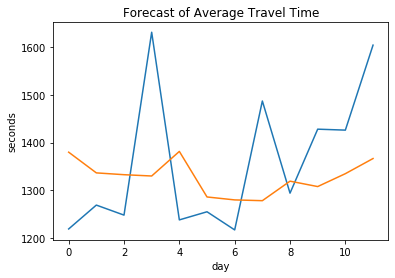

In [166]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
avg_time_data = palace_embar_df['Daily Mean Travel Time (Seconds)']
# transform data to be stationary
raw_values = avg_time_data.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 25, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.ylabel('seconds')
plt.xlabel('day')
plt.title('Forecast of Average Travel Time')
plt.show()